In [1]:
import os

import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import torch
from dysts.base import DynSys
from scipy.integrate import solve_ivp

from panda.utils.data_utils import safe_standardize
from panda.utils.plot_utils import apply_custom_style

apply_custom_style("../../config/plotting.yaml")

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/stor/home/jl82436/panda/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class KuramotoShivashinsky(DynSys):
    """Implements the 1+1D KS equation in fourier space"""

    def __init__(self, L: float, modes: int):
        self.ic = None
        super().__init__(metadata_path=None, dimension=2 * modes, parameters={})
        self.L = L
        self.modes = modes
        self.dimension = 2 * self.modes
        self.wave_nums = 2 * np.pi * np.arange(0, self.modes + 2) / self.L
        self.N = self.dimension + 2

        # precompute some quantities
        self.freq_domain = np.zeros(self.modes + 2, dtype=np.complex128)
        self.nonlinear_factor = -0.5 * 1j * self.wave_nums * self.N
        self.diffusion_ffts = self.wave_nums**2 - self.wave_nums**4

    def to_spatial(self, q: np.ndarray, N: int) -> np.ndarray:
        """Inverse FFT of the modes to get u(x) at a certain time

        :param q: array of flattened fourier coefficients (real and imag components), can have batch dimensions
        :param N: grid resolution in the spatial domain

        :returns: solution in the spatial domain
        """
        coeffs = np.zeros(q.shape[:-1] + (self.modes + 2,), dtype=complex)
        coeffs[..., 1:-1] = q[..., : self.modes] + 1j * q[..., self.modes :]
        return np.fft.irfft(coeffs, n=N)

    def rhs(self, t: float, X: np.ndarray) -> np.ndarray:
        self.freq_domain[1:-1] = X[: self.modes] + 1j * X[self.modes :]
        u = np.fft.irfft(self.freq_domain, n=self.N)
        pseudospectral_term = self.nonlinear_factor * np.fft.rfft(u * u)
        linear_term = self.diffusion_ffts * self.freq_domain

        # repackage components
        flow = (linear_term + pseudospectral_term)[1:-1]
        return np.concatenate([np.real(flow), np.imag(flow)])

In [3]:
tfinal = 100
ks = KuramotoShivashinsky(L=100, modes=64)

In [4]:
save_dir = "../../outputs/kuramoto_sivashinsky"
os.makedirs(save_dir, exist_ok=True)

n_runs = 40
parent_rng = np.random.default_rng(12)
rng_stream = parent_rng.spawn(n_runs)
traj_path = os.path.join(save_dir, f"trajectories_{n_runs}.npy")
if os.path.exists(traj_path):
    trajectories = np.load(traj_path, allow_pickle=True)
else:
    trajectories = []
    for rng in rng_stream:
        ic = 0.1 * rng.normal(size=(ks.dimension,))
        teval = np.linspace(0, tfinal, 4096)
        sol = solve_ivp(ks.rhs, (0, tfinal), ic, method="DOP853", t_eval=teval, rtol=1e-8, atol=1e-8)
        ts, freq_traj = sol.t, sol.y.T
        trajectories.append(ks.to_spatial(freq_traj, N=ks.dimension))
    np.save(traj_path, trajectories)

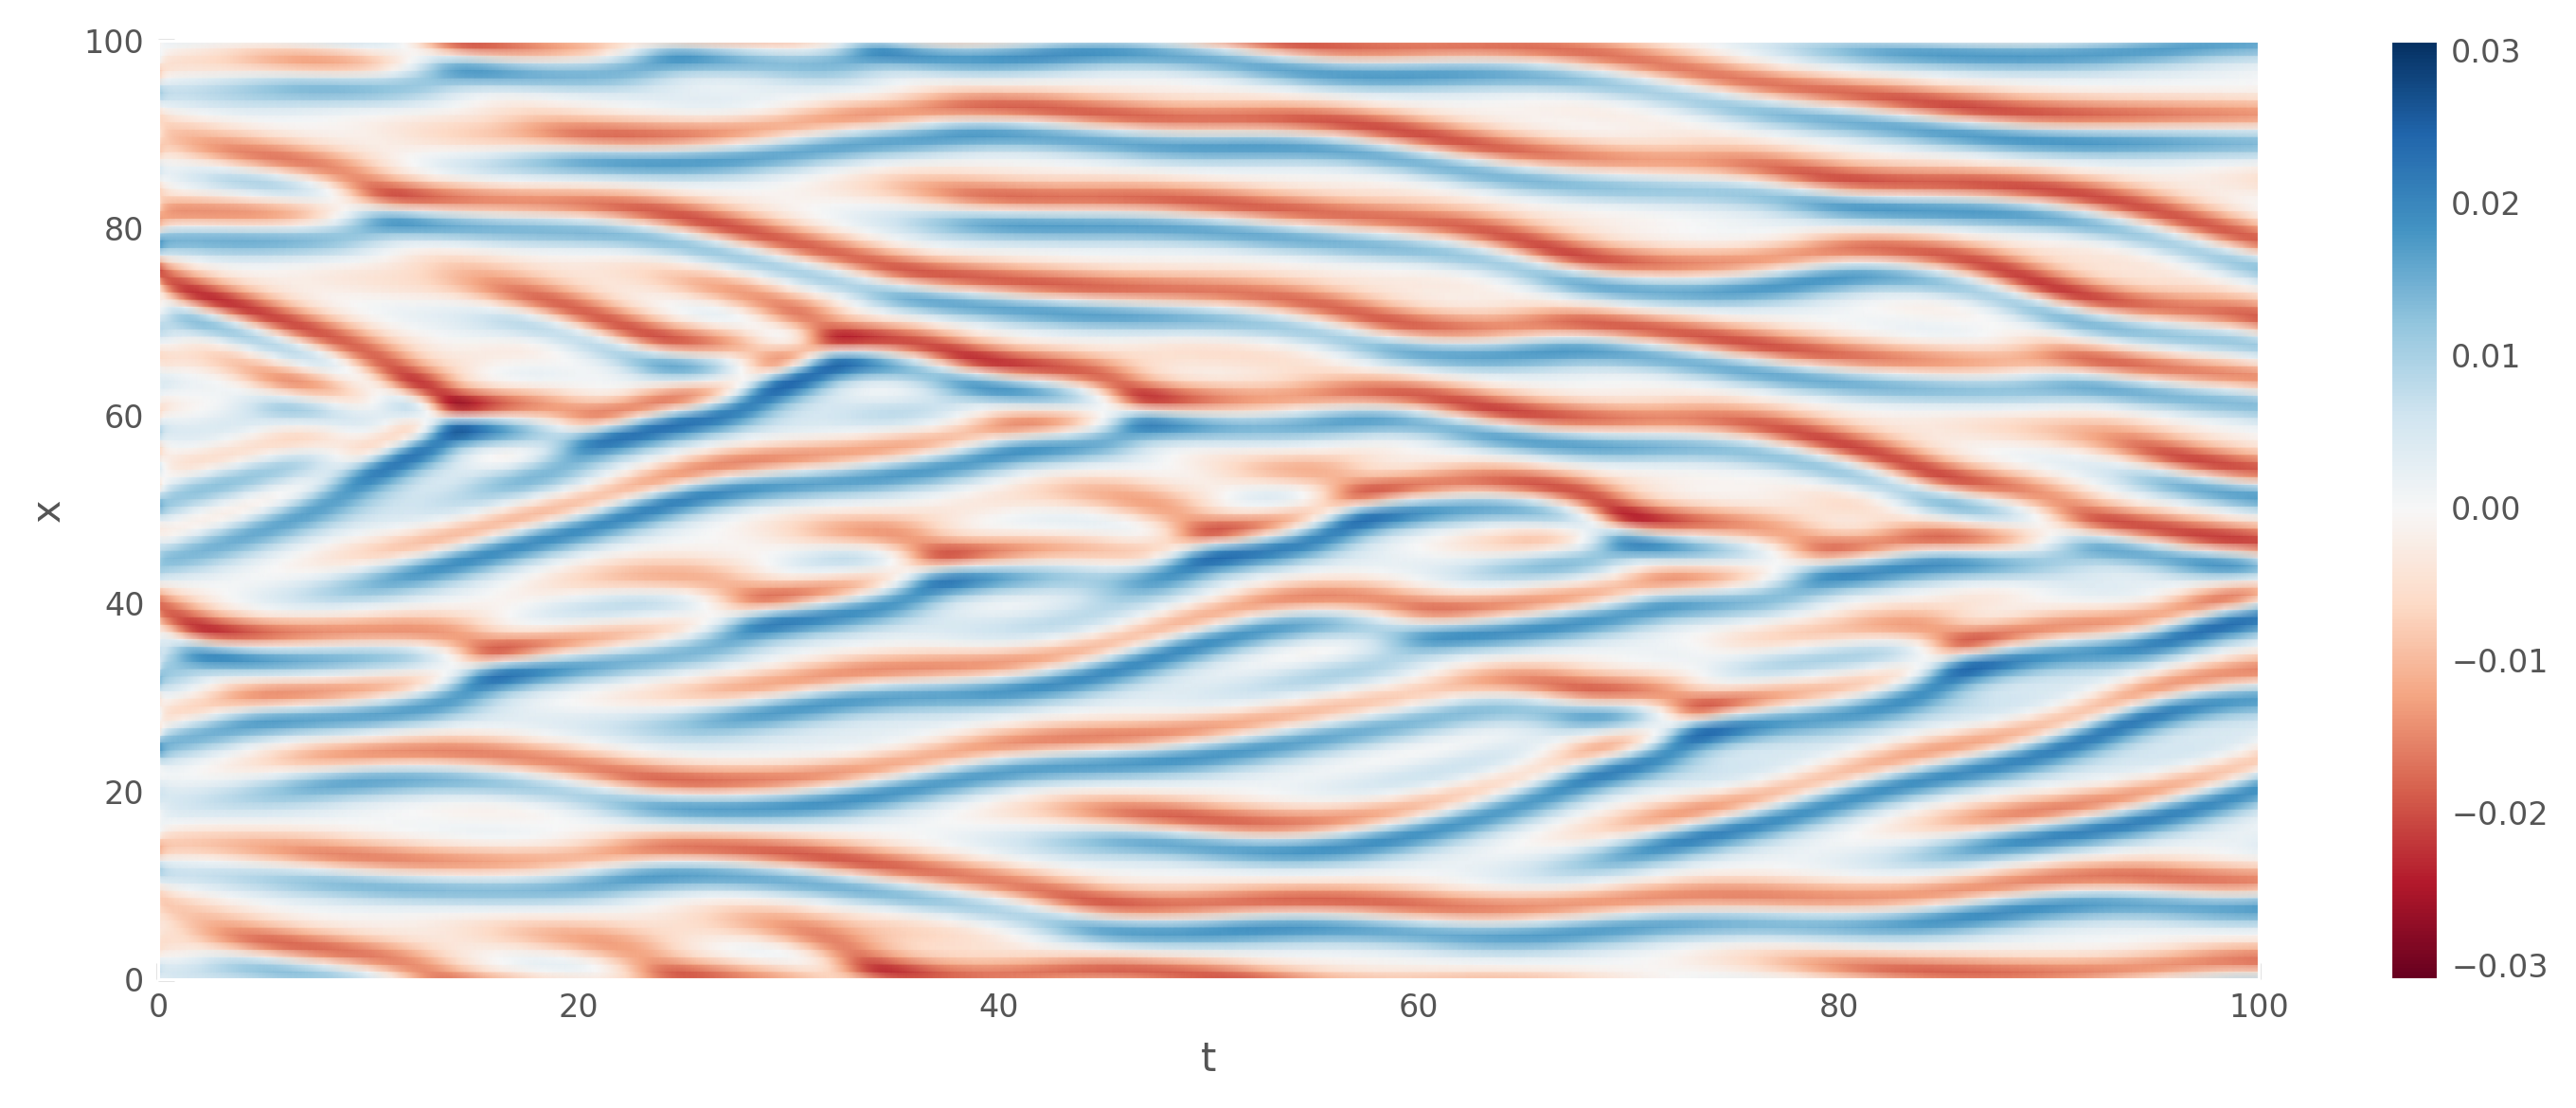

In [5]:
# plot sample trajectory
ts = np.linspace(0, tfinal, 4096)
grid = np.linspace(0, ks.L, ks.dimension)
plt.figure(figsize=(10, 4))
plt.pcolormesh(ts, grid, trajectories[0].T, cmap="RdBu", shading="gouraud")
plt.colorbar()
plt.ylabel("x")
plt.xlabel("t")
plt.show()

In [6]:
start_time = 1024
context_length = 512
prediction_length = 512
end_time = start_time + context_length + prediction_length

In [7]:
trajs = np.stack(trajectories, axis=0)[:, start_time:end_time]

In [8]:
import glob
import os


class KeepLatestBest(dde.callbacks.ModelCheckpoint):
    def __init__(self, fixed_prefix, **kwargs):
        super().__init__(filepath=fixed_prefix, **kwargs)
        self.fixed_prefix = fixed_prefix

    def on_epoch_end(self):
        super().on_epoch_end()  # lets DeepXDE save e.g. best-12345.pt
        files = sorted(glob.glob(self.filepath + "-*"))
        if not files:
            return
        latest = files[-1]
        _, ext = os.path.splitext(latest)
        fixed = self.fixed_prefix + ext
        for f in files[:-1]:
            os.remove(f)
        os.replace(latest, fixed)

Compiling model...
'compile' took 0.000251 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.36e+01]    [7.82e+01]    [2.28e+00]    


1000      [9.50e-01]    [1.88e+01]    [1.04e+00]    
2000      [9.56e-01]    [1.82e+01]    [1.01e+00]    
3000      [9.51e-01]    [1.78e+01]    [9.98e-01]    
4000      [9.17e-01]    [1.76e+01]    [9.93e-01]    
5000      [8.79e-01]    [1.75e+01]    [9.86e-01]    
6000      [9.20e-01]    [1.75e+01]    [9.88e-01]    
7000      [8.18e-01]    [1.73e+01]    [9.79e-01]    
8000      [8.37e-01]    [1.72e+01]    [9.73e-01]    
9000      [8.10e-01]    [1.71e+01]    [9.67e-01]    
10000     [7.73e-01]    [1.69e+01]    [9.59e-01]    
11000     [6.86e-01]    [1.65e+01]    [9.43e-01]    
12000     [5.93e-01]    [1.62e+01]    [9.30e-01]    
13000     [5.95e-01]    [1.60e+01]    [9.19e-01]    
14000     [5.52e-01]    [1.58e+01]    [9.09e-01]    
15000     [4.92e-01]    [1.54e+01]    [8.93e-01]    
16000     [4.51e-01]    [1.52e+01]    [8.83e-01]    
17000     [4.12e-01]    [1.50e+01]    [8.73e-01]    
18000     [3.58e-01]    [1.48e+01]    [8.59e-01]    
19000     [2.96e-01]    [1.45e+01]    [8.44e-0

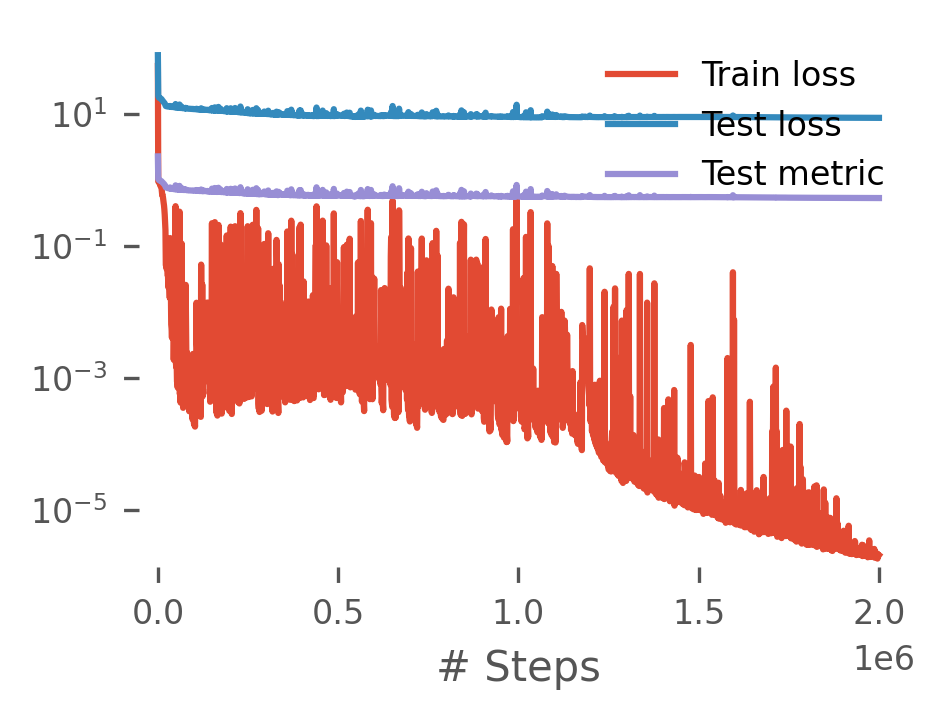

In [18]:
device_rank = 1
device = torch.device(f"cuda:{device_rank}")
torch.set_default_device(device)


xs = np.linspace(0, ks.L, ks.dimension)
xs = xs.astype(np.float32).reshape(-1, 1)  # (N,1)

stand_trajs = safe_standardize(trajs, axis=1, context=trajs[:, :context_length])
xtrain = (stand_trajs[:, : context_length - 1].astype(np.float32).reshape(-1, ks.dimension), xs)
ytrain = stand_trajs[:, 1:context_length].astype(np.float32).reshape(-1, ks.dimension)
xtest = (stand_trajs[:, context_length:-1].astype(np.float32).reshape(-1, ks.dimension), xs)
ytest = stand_trajs[:, context_length + 1 :].astype(np.float32).reshape(-1, ks.dimension)

data = dde.data.TripleCartesianProd(X_train=xtrain, y_train=ytrain, X_test=xtest, y_test=ytest)

hidden_dim = 256
n_layers = 6
net = dde.nn.DeepONetCartesianProd(
    [ks.dimension] + n_layers * [hidden_dim],
    [1] + n_layers * [hidden_dim],
    "tanh",
    "He normal",
)

model = dde.Model(data, net)

batch_size = 512
iterations = 2000000
ckpt = KeepLatestBest(
    "ks_ckpt/deeponet",
    save_better_only=True,
    monitor="test loss",
    period=1,
)
optimizer = torch.optim.AdamW(net.parameters(), lr=3e-4)
model.compile(optimizer, decay=("cosine", iterations, 1e-6), metrics=["mean l2 relative error"])
losshistory, train_state = model.train(iterations=iterations, batch_size=batch_size, callbacks=[ckpt])

dde.utils.plot_loss_history(losshistory)
plt.show()


In [22]:
def plot_forecast(
    ts: np.ndarray,
    grid: np.ndarray,
    trajectory: np.ndarray,
    predictions: np.ndarray,
    run_name: str = "",
    context_length: int = 512,
    save_path: str | None = None,
    v_abs: float | None = None,
    prediction_horizon: int = 128,
    cmap_name: str = "RdBu",
    title_kwargs: dict = {},
    draw_prediction_horizon_line: bool = True,
    figsize: tuple[int, int] = (9, 9),
    show_cbar: bool = True,
    show_ticks: bool = True,
    show_axes_labels: bool = True,
    show_context: bool = True,
):
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=figsize)

    vmin = min(trajectory.min(), predictions.min())
    vmax = max(trajectory.max(), predictions.max())
    vabs = v_abs or max(abs(vmin), abs(vmax))

    if not show_context:
        ts = ts[context_length:]
    for i, (ax, data, label) in enumerate(
        zip(
            axes,
            [trajectory, predictions, predictions - trajectory],
            [
                "Ground Truth",
                f"Predictions ({run_name})" if run_name else "Predictions",
                "Error",
                # f"Prediction Error ({np.mean(np.abs(predictions[context_length:] - trajectory[context_length:])):.2e}) ({run_name})",
            ],
        )
    ):
        if not show_context:
            data = data[context_length:]
        im = ax.pcolormesh(ts, grid, data.T, cmap=cmap_name, shading="gouraud", vmin=-vabs, vmax=vabs)
        if show_ticks:
            ax.set_ylabel("x")
        else:
            ax.set_yticks([])

        ax.set_title(label, **title_kwargs)
        if show_cbar:
            fig.colorbar(im, ax=ax)
        # draw black vertical line at middle of plot (x axis middle)

        if show_context:
            ax.axvline(ts[context_length], color="black", linewidth=1)

        if i == 2 and draw_prediction_horizon_line:
            # draw a black dotted vertical line at the end of 128 pred length window
            start = context_length if show_context else 0
            ax.axvline(
                ts[start + prediction_horizon],
                color="gray",
                linestyle="--",
                linewidth=1,
            )
    if show_ticks:
        axes[-1].set_xlabel("t")
        # axes[-1].set_xticks(ts[::256])
    else:
        for ax in axes:
            ax.set_xticks([])
            ax.set_yticks([])

    if show_axes_labels:
        axes[-1].set_xlabel("Time", fontweight="bold")
        for ax in axes:
            ax.set_ylabel("x", fontweight="bold")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")

    return vabs


def rollout_deeponet(model, Z_feats, u0, steps):
    N = u0.shape[0]
    preds = np.empty((steps, N), dtype=np.float32)
    u = u0.astype(np.float32).copy()
    for s in range(steps):
        Vb = u.reshape(1, -1)  # branch: current state (1, N)
        preds[s] = model.predict((Vb, Z_feats))[0]  # next state (N,)
        u = preds[s]
    return preds  # (steps, N)

In [23]:
# load best model
WORK_DIR = os.path.expandvars("$WORK")
# model.restore(f"{WORK_DIR}/checkpoints/KS_baselines/deeponet.pt", device=device)
model.restore("ks_ckpt/deeponet.pt", device=device)

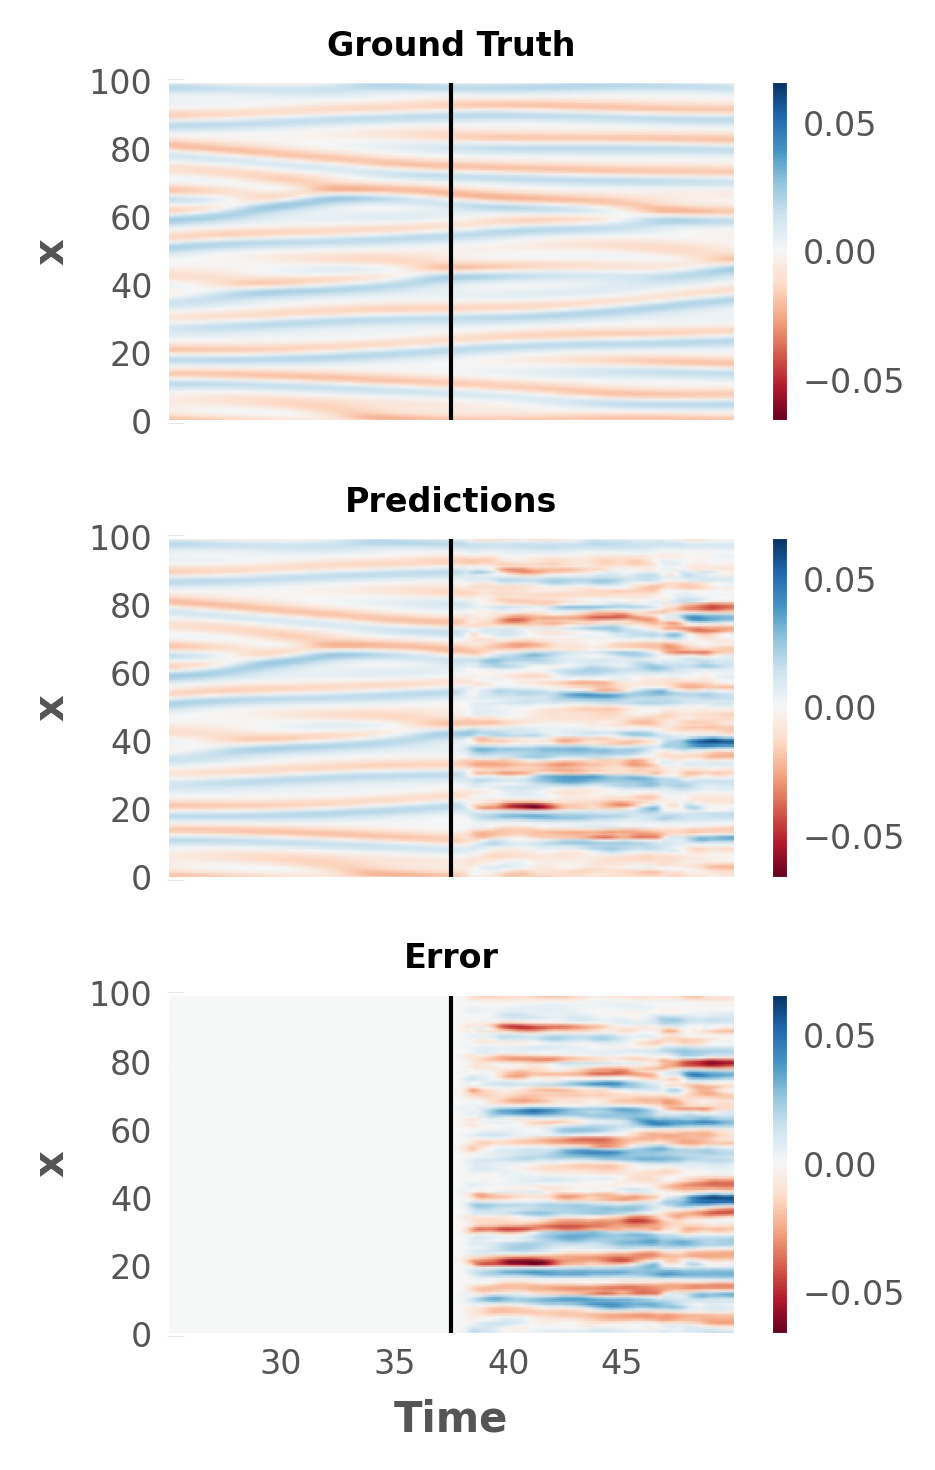

In [25]:
# visualize sample prediction
sample = 0
u0 = stand_trajs[sample, context_length - 1].astype(np.float32)
pred_seq = rollout_deeponet(model, xs, u0, prediction_length)  # (prediction_length, N)
prediction = np.concatenate([stand_trajs[sample, :context_length], pred_seq], axis=0)
prediction_traj = safe_standardize(prediction, axis=0, denormalize=True, context=trajs[sample, :context_length])

_ = plot_forecast(
    ts[start_time:end_time],
    grid,
    trajs[sample, :end_time],
    prediction_traj,
    context_length=context_length,
    cmap_name="RdBu",
    show_context=True,
    figsize=(3.2, 5),
    title_kwargs={"fontweight": "bold", "fontsize": 8},
    draw_prediction_horizon_line=False,
)